In [1]:
from qiskit import *
#from zero_noise_extrapolation import *
from anti import *
from GenerateRandomCircuit import *
import numpy as np
import pylab as pl
from qiskit.providers.jobstatus import JOB_FINAL_STATES, JobStatus

In [2]:
import sys
sys.path.append('../')

from qiskit_utilities.utilities import *

In [3]:
# show all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

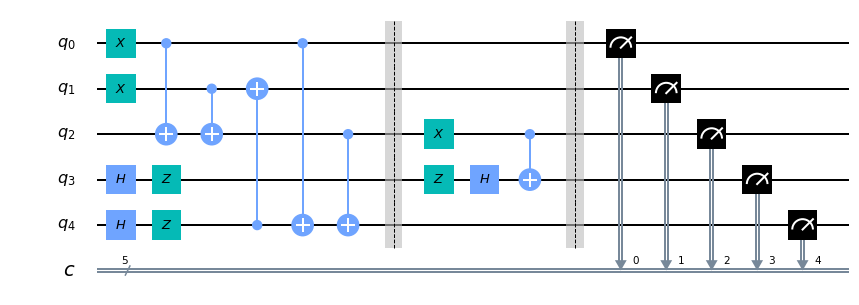

In [4]:
def get_maxs_poker_circuit(usebarrier=False, measure=True, applynotpos=-1):
    circ = "OPENQASM 2.0;\ninclude \"qelib1.inc\"; \
    qreg q[5];\
    creg c[5];"
    if applynotpos>-1 and applynotpos<5:
        circ = circ + "x q["+str(applynotpos)+"];"
    circ = circ + "x q[0];\
    x q[1];\
    h q[3];\
    z q[3];\
    h q[4];\
    z q[4];\
    cx q[0],q[2];\
    cx q[1],q[2];\
    cx q[4],q[1];\
    cx q[0],q[4];\
    cx q[2],q[4];"
    if usebarrier:
        circ = circ + "barrier q[0],q[1],q[2],q[3],q[4]; "
    circ = circ + "x q[2];\
    z q[3];\
    h q[3];\
    cx q[2],q[3];"
    if usebarrier:
        circ = circ + "barrier q[0],q[1],q[2],q[3],q[4]; "
    if measure:
        circ = circ + "measure q[0] -> c[0]; \
        measure q[1] -> c[1]; \
        measure q[2] -> c[2]; \
        measure q[3] -> c[3]; \
        measure q[4] -> c[4]; "
    qc = QuantumCircuit.from_qasm_str(circ)
    return qc

circ=get_maxs_poker_circuit(True)
get_maxs_poker_circuit(True).draw(output='mpl')

In [5]:
print(circ.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[5];
x q[0];
x q[1];
cx q[0],q[2];
cx q[1],q[2];
h q[3];
z q[3];
h q[4];
z q[4];
cx q[4],q[1];
cx q[0],q[4];
cx q[2],q[4];
barrier q[0],q[1],q[2],q[3],q[4];
x q[2];
z q[3];
h q[3];
cx q[2],q[3];
barrier q[0],q[1],q[2],q[3],q[4];
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];



In [6]:
jobs_dict={}
E_dict={}
E_av_dict={}
mean_depth_dict={}
mean_depth_transpiled_dict={}
max_depth_dict={}
max_depth_transpiled_dict={}
backends_dict={}
noisemodels_dict={}
coupling_maps_dict={}
basis_gates_dict={}
cx_error_maps_dict={}

In [7]:
import pickle
import os

In [8]:
if os.path.isfile('E_Pokerdata'):
    infile = open('data/E_Pokerdata','rb')
    E_dict = pickle.load(infile)
    infile.close()
    
if os.path.isfile('E_av_Pokerdata'):
    infile = open('data/E_av_Pokerdata','rb')
    E_av_dict = pickle.load(infile)
    infile.close()

if os.path.isfile('data/mean_depth_Pokerdata'):
    infile = open('data/mean_depth_Pokerdata','rb')
    mean_depth_dict = pickle.load(infile)
    infile.close()
    
if os.path.isfile('data/mean_depth_transpiled_Pokerdata'):
    infile = open('data/mean_depth_transpiled_Pokerdata','rb')
    mean_depth_transpiled_dict = pickle.load(infile)
    infile.close()

if os.path.isfile('data/max_depth_Pokerdata'):
    infile = open('data/max_depth_Pokerdata','rb')
    max_depth_dict = pickle.load(infile)
    infile.close()

if os.path.isfile('data/max_depth_transpiled_Pokerdata'):
    infile = open('data/max_depth_transpiled_Pokerdata','rb')
    max_depth_transpiled_dict = pickle.load(infile)
    infile.close()

Let us first create a dictionary with backends we are going to use

In [9]:
backendname_sim = 'qasm_simulator'
backends_dict[backendname_sim] = Aer.get_backend(backendname_sim)

#load IBMQ account
#IBMQ.save_account('yourToken')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

backendname_x2 = 'ibmqx2'
backendname_ourense = 'ibmq_ourense'

for backendname in [backendname_x2, backendname_ourense]:
    backends_dict[backendname] = provider.get_backend(backendname)

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

Next, let us create some noise models for the ibm quantum devices

In [10]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.device import basic_device_noise_model


for backendname in [backendname_x2, backendname_ourense]:
    backend = backends_dict[backendname]

    noisemodels_dict[backendname] = basic_device_noise_model(backend.properties())
    cx_error_maps_dict[backendname] = get_cx_error_map(backend)
    coupling_maps_dict[backendname] = backend.configuration().coupling_map
    basis_gates_dict[backendname] = noisemodels_dict[backendname].basis_gates
    print(backendname, ': ', noisemodels_dict[backendname])

noisemodels_dict['None'] = None

ibmqx2 :  NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['id', 'u2', 'u3', 'cx', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [2, 3]), ('cx', [2, 4]), ('cx', [3, 2]), ('cx', [3, 4]), ('cx', [4, 2]), ('cx', [4, 3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]
ibmq_ourense :  NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['id', 'u2', 'u3', 'cx', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0])

Next, we implement how the expectation value of our observable is defined, and how to extract it from the executed jobs

In [11]:
numones=np.zeros((2**5,1))
for i in range(2**5):
    numones[i]=bin(i).count("1")

In [12]:
def expectationValue(results):
    #num_qubits = results[0].header.n_qubits
    E=np.zeros((len(results),1))
    for item in range(0,len(results)):
        shots = results[item].shots
        counts = results[item].data.counts
        for key in list(counts.__dict__.keys()):
            c=getattr(counts, key)#number of counts
            E[item] += numones[int(key,0)]*c/shots
    return E

In [13]:
def getE(jobstring, numparts):
    for p in range(1, numparts+1):
        filename = jobstring+'_part_'+str(p)
        results = read_results(filename)
        if results == None:
            return None, None, False
        if p==1:
            E = expectationValue(results)
        else:
            E = np.append(E, expectationValue(results))

    E_conv = np.zeros_like(E)
    for j in range(1,num_repetitions+1):
        E_conv[j-1] = sum(E[0:j])/j
    return E, E_conv, True

Let us start by simulating the circuit on an ideal simulator without noise

in all simulations we will use the same number repetitions, where each repetition consists of shots

on real ibm devices we are only allowed $2^6$ circuits in parallel, therefore we need to do $2^4$ parts in order to get $2^{10}$ repetitions in total

In [14]:
num_circuits=2**6
num_parts=2**3
num_repetitions = num_circuits*num_parts
shots = 1024*2*2

Read the expectation values from file, or execute the circuits on a simulator

Original:


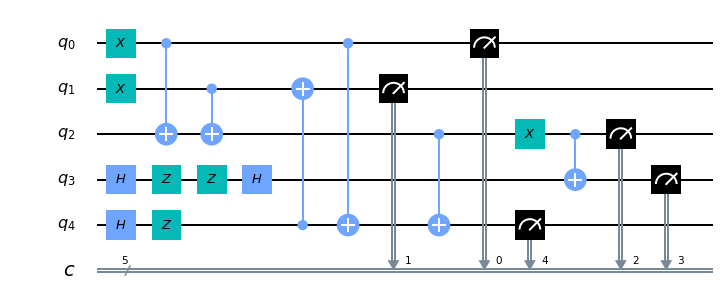

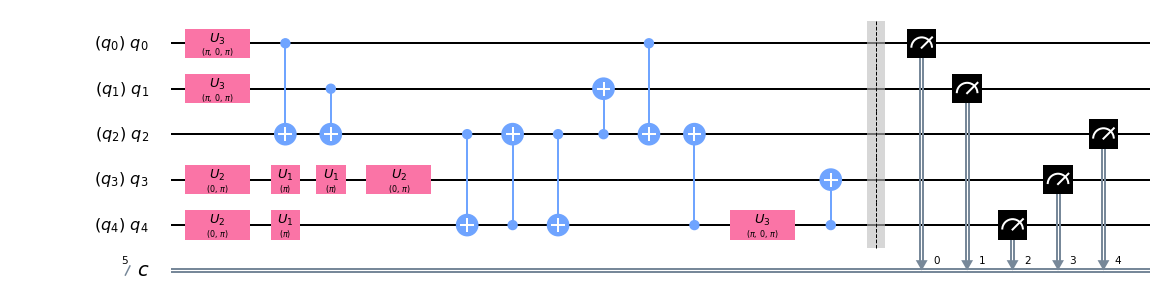

Anti:
OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[5];
u3(3.141592653589793,0,3.141592653589793) q[0];
u3(3.141592653589793,0,3.141592653589793) q[1];
cx q[0],q[2];
cx q[1],q[2];
u2(0,3.141592653589793) q[3];
u1(3.141592653589793) q[3];
u1(3.141592653589793) q[3];
u2(0,3.141592653589793) q[3];
u2(0,3.141592653589793) q[4];
u1(3.141592653589793) q[4];
cx q[2],q[4];
cx q[4],q[2];
cx q[2],q[4];
cx q[2],q[1];
cx q[0],q[2];
cx q[4],q[2];
u3(3.141592653589793,0,3.141592653589793) q[4];
cx q[4],q[3];
barrier q[0],q[1],q[4],q[3],q[2];
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[4] -> c[2];
measure q[3] -> c[3];
measure q[2] -> c[4];



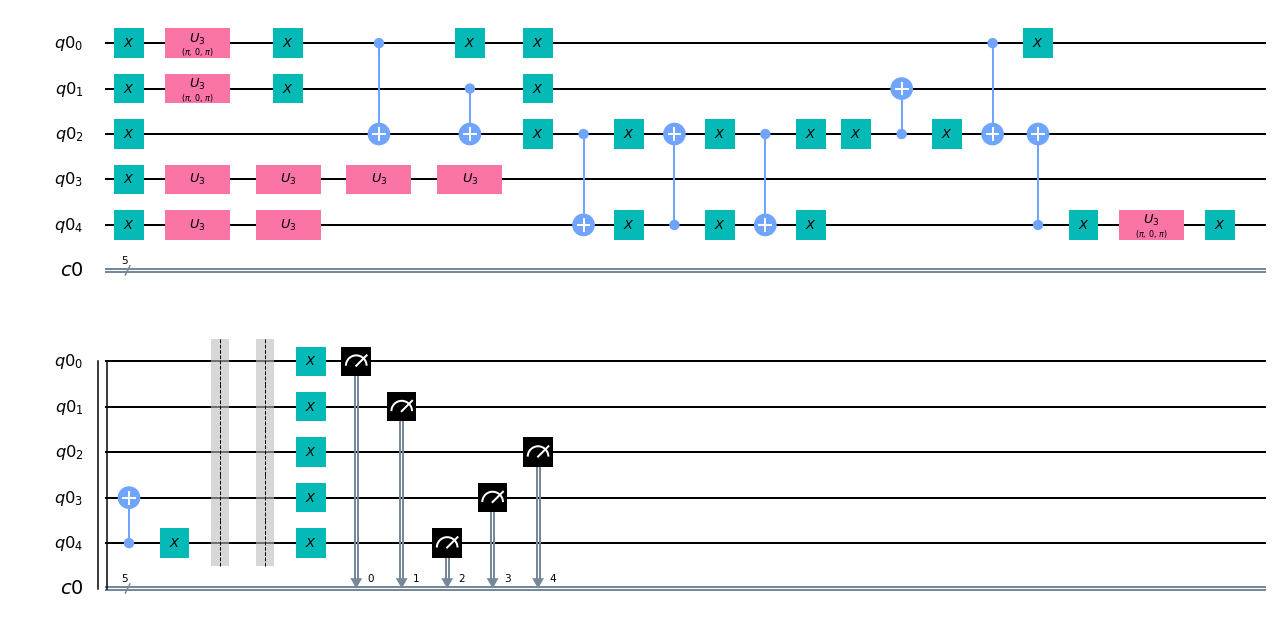

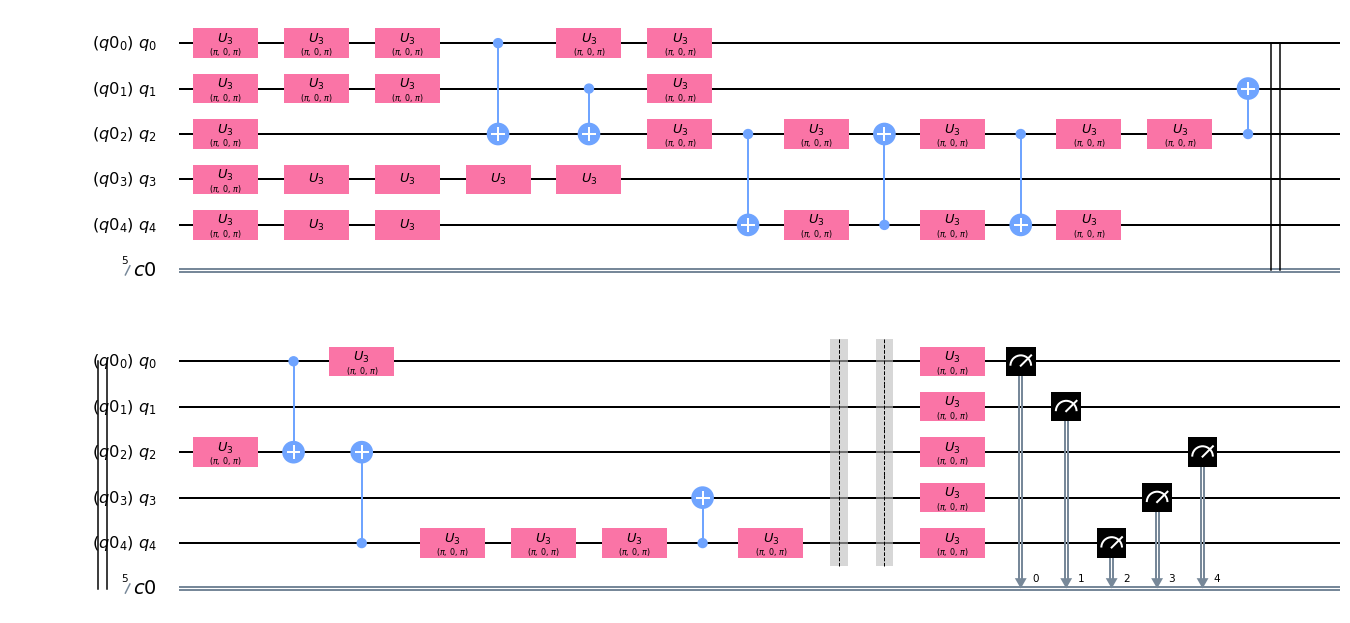

Flip-at-start:
OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[5];
u3(3.141592653589793,0,3.141592653589793) q[0];
u3(3.141592653589793,0,3.141592653589793) q[1];
cx q[0],q[2];
cx q[1],q[2];
u2(0,3.141592653589793) q[3];
u1(3.141592653589793) q[3];
u1(3.141592653589793) q[3];
u2(0,3.141592653589793) q[3];
u2(0,3.141592653589793) q[4];
u1(3.141592653589793) q[4];
cx q[2],q[4];
cx q[4],q[2];
cx q[2],q[4];
cx q[2],q[1];
cx q[0],q[2];
cx q[4],q[2];
u3(3.141592653589793,0,3.141592653589793) q[4];
cx q[4],q[3];
barrier q[0],q[1],q[4],q[3],q[2];
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[4] -> c[2];
measure q[3] -> c[3];
measure q[2] -> c[4];



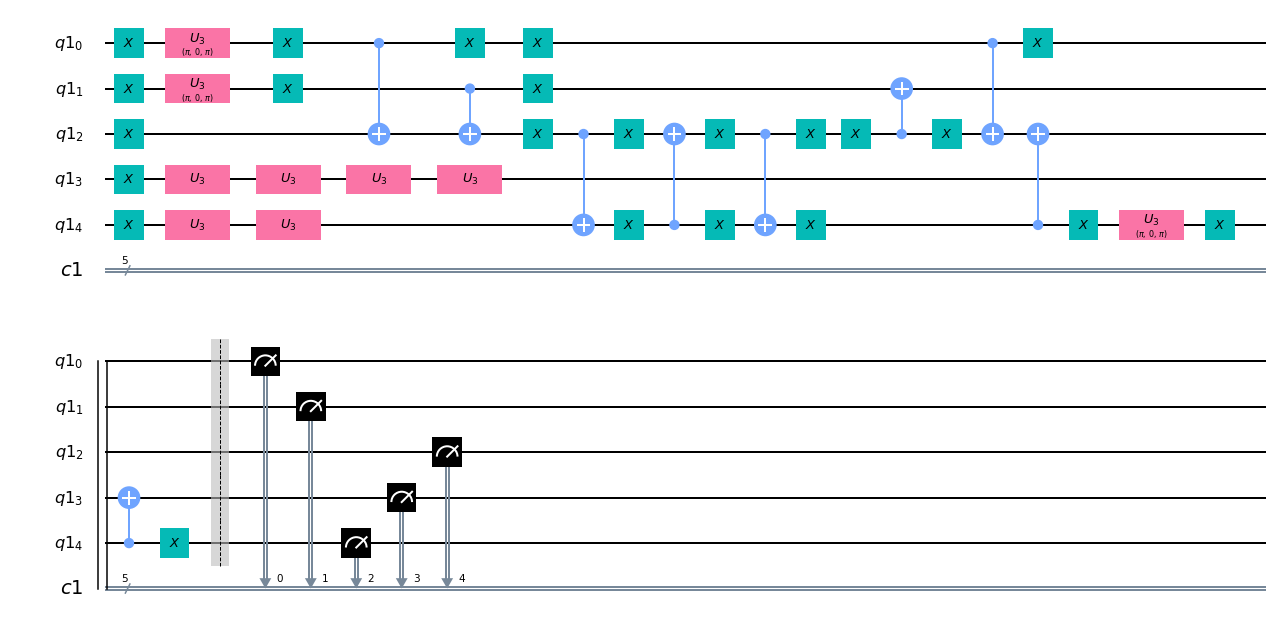

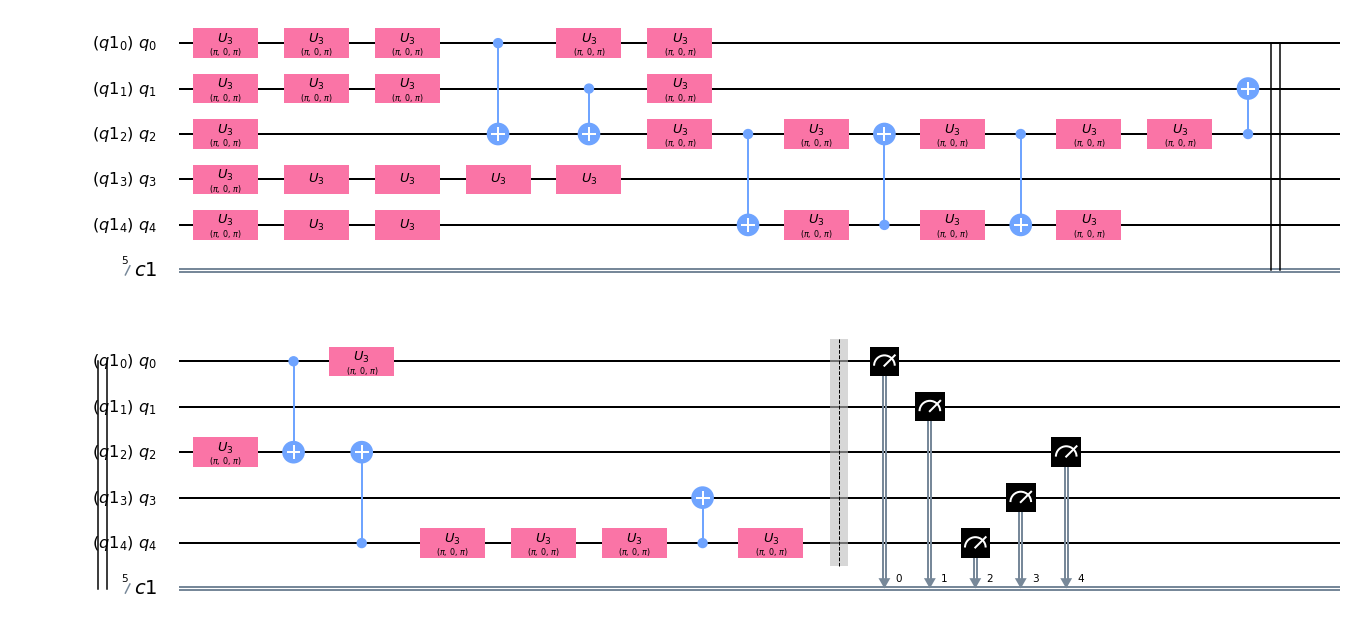

Flip-at-end:
OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[5];
u3(3.141592653589793,0,3.141592653589793) q[0];
u3(3.141592653589793,0,3.141592653589793) q[1];
cx q[0],q[2];
cx q[1],q[2];
u2(0,3.141592653589793) q[3];
u1(3.141592653589793) q[3];
u1(3.141592653589793) q[3];
u2(0,3.141592653589793) q[3];
u2(0,3.141592653589793) q[4];
u1(3.141592653589793) q[4];
cx q[2],q[4];
cx q[4],q[2];
cx q[2],q[4];
cx q[2],q[1];
cx q[0],q[2];
cx q[4],q[2];
u3(3.141592653589793,0,3.141592653589793) q[4];
cx q[4],q[3];
barrier q[0],q[1],q[4],q[3],q[2];
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[4] -> c[2];
measure q[3] -> c[3];
measure q[2] -> c[4];



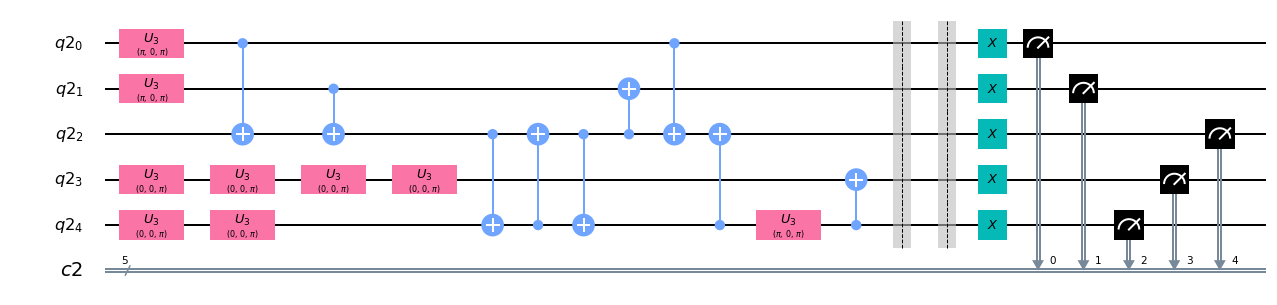

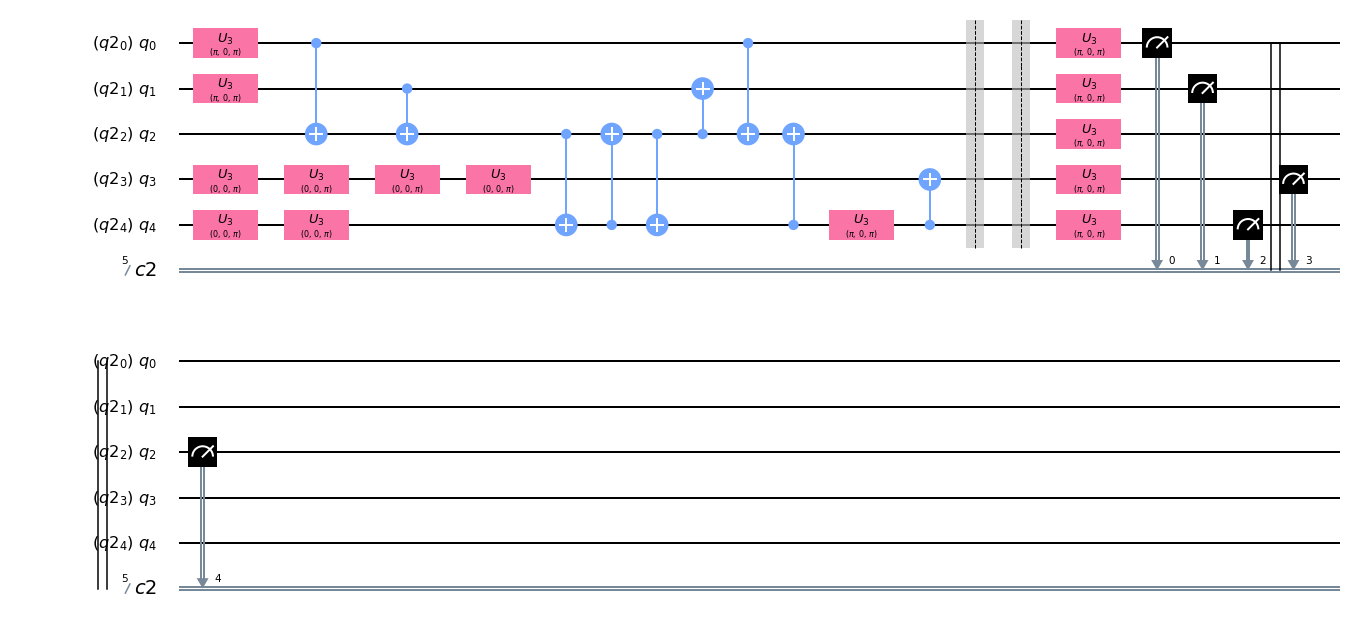

times3:
OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[5];
u3(3.141592653589793,0,3.141592653589793) q[0];
u3(3.141592653589793,0,3.141592653589793) q[1];
cx q[0],q[2];
cx q[1],q[2];
u2(0,3.141592653589793) q[3];
u1(3.141592653589793) q[3];
u1(3.141592653589793) q[3];
u2(0,3.141592653589793) q[3];
u2(0,3.141592653589793) q[4];
u1(3.141592653589793) q[4];
cx q[2],q[4];
cx q[4],q[2];
cx q[2],q[4];
cx q[2],q[1];
cx q[0],q[2];
cx q[4],q[2];
u3(3.141592653589793,0,3.141592653589793) q[4];
cx q[4],q[3];
barrier q[0],q[1],q[4],q[3],q[2];
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[4] -> c[2];
measure q[3] -> c[3];
measure q[2] -> c[4];



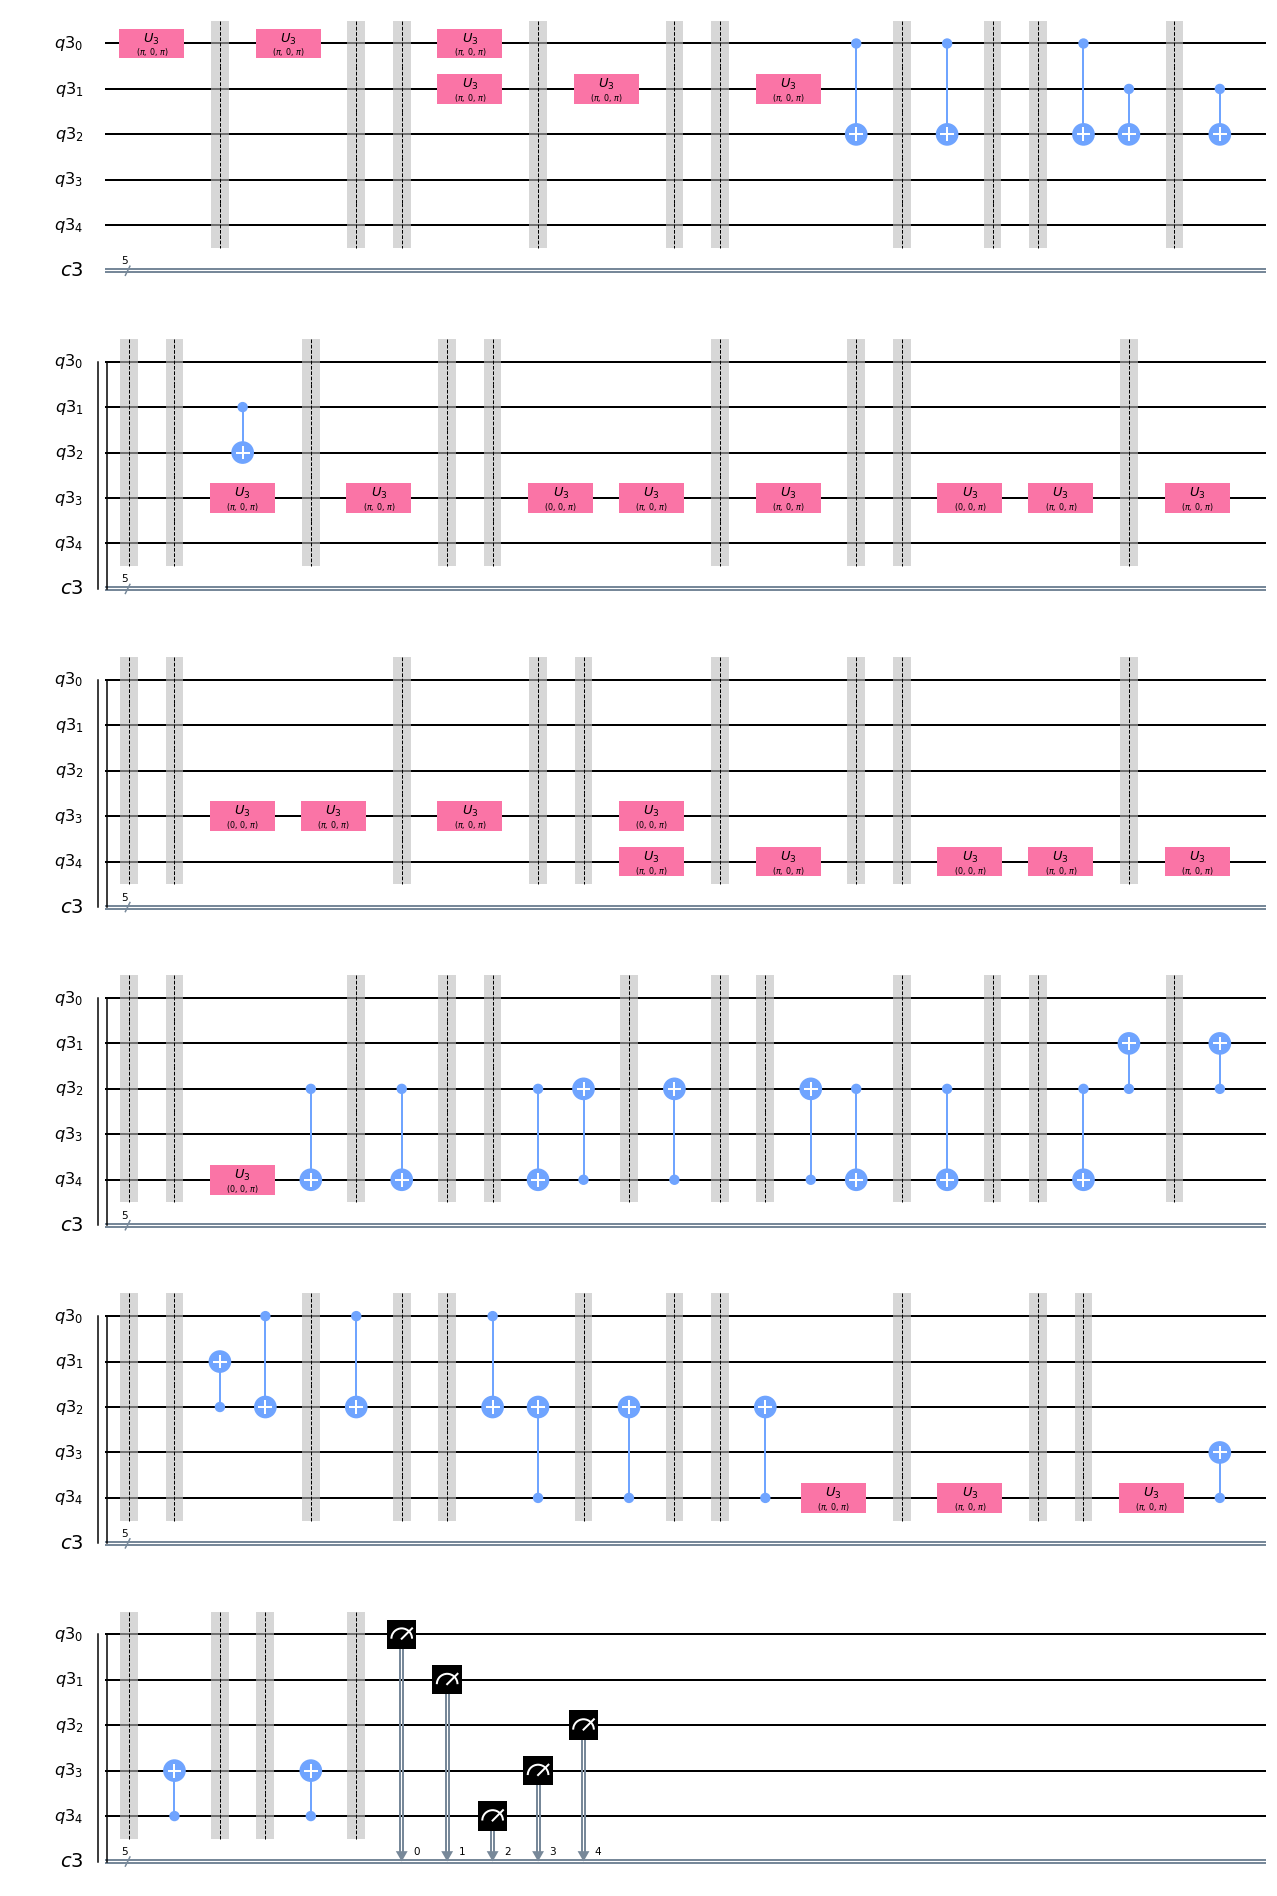

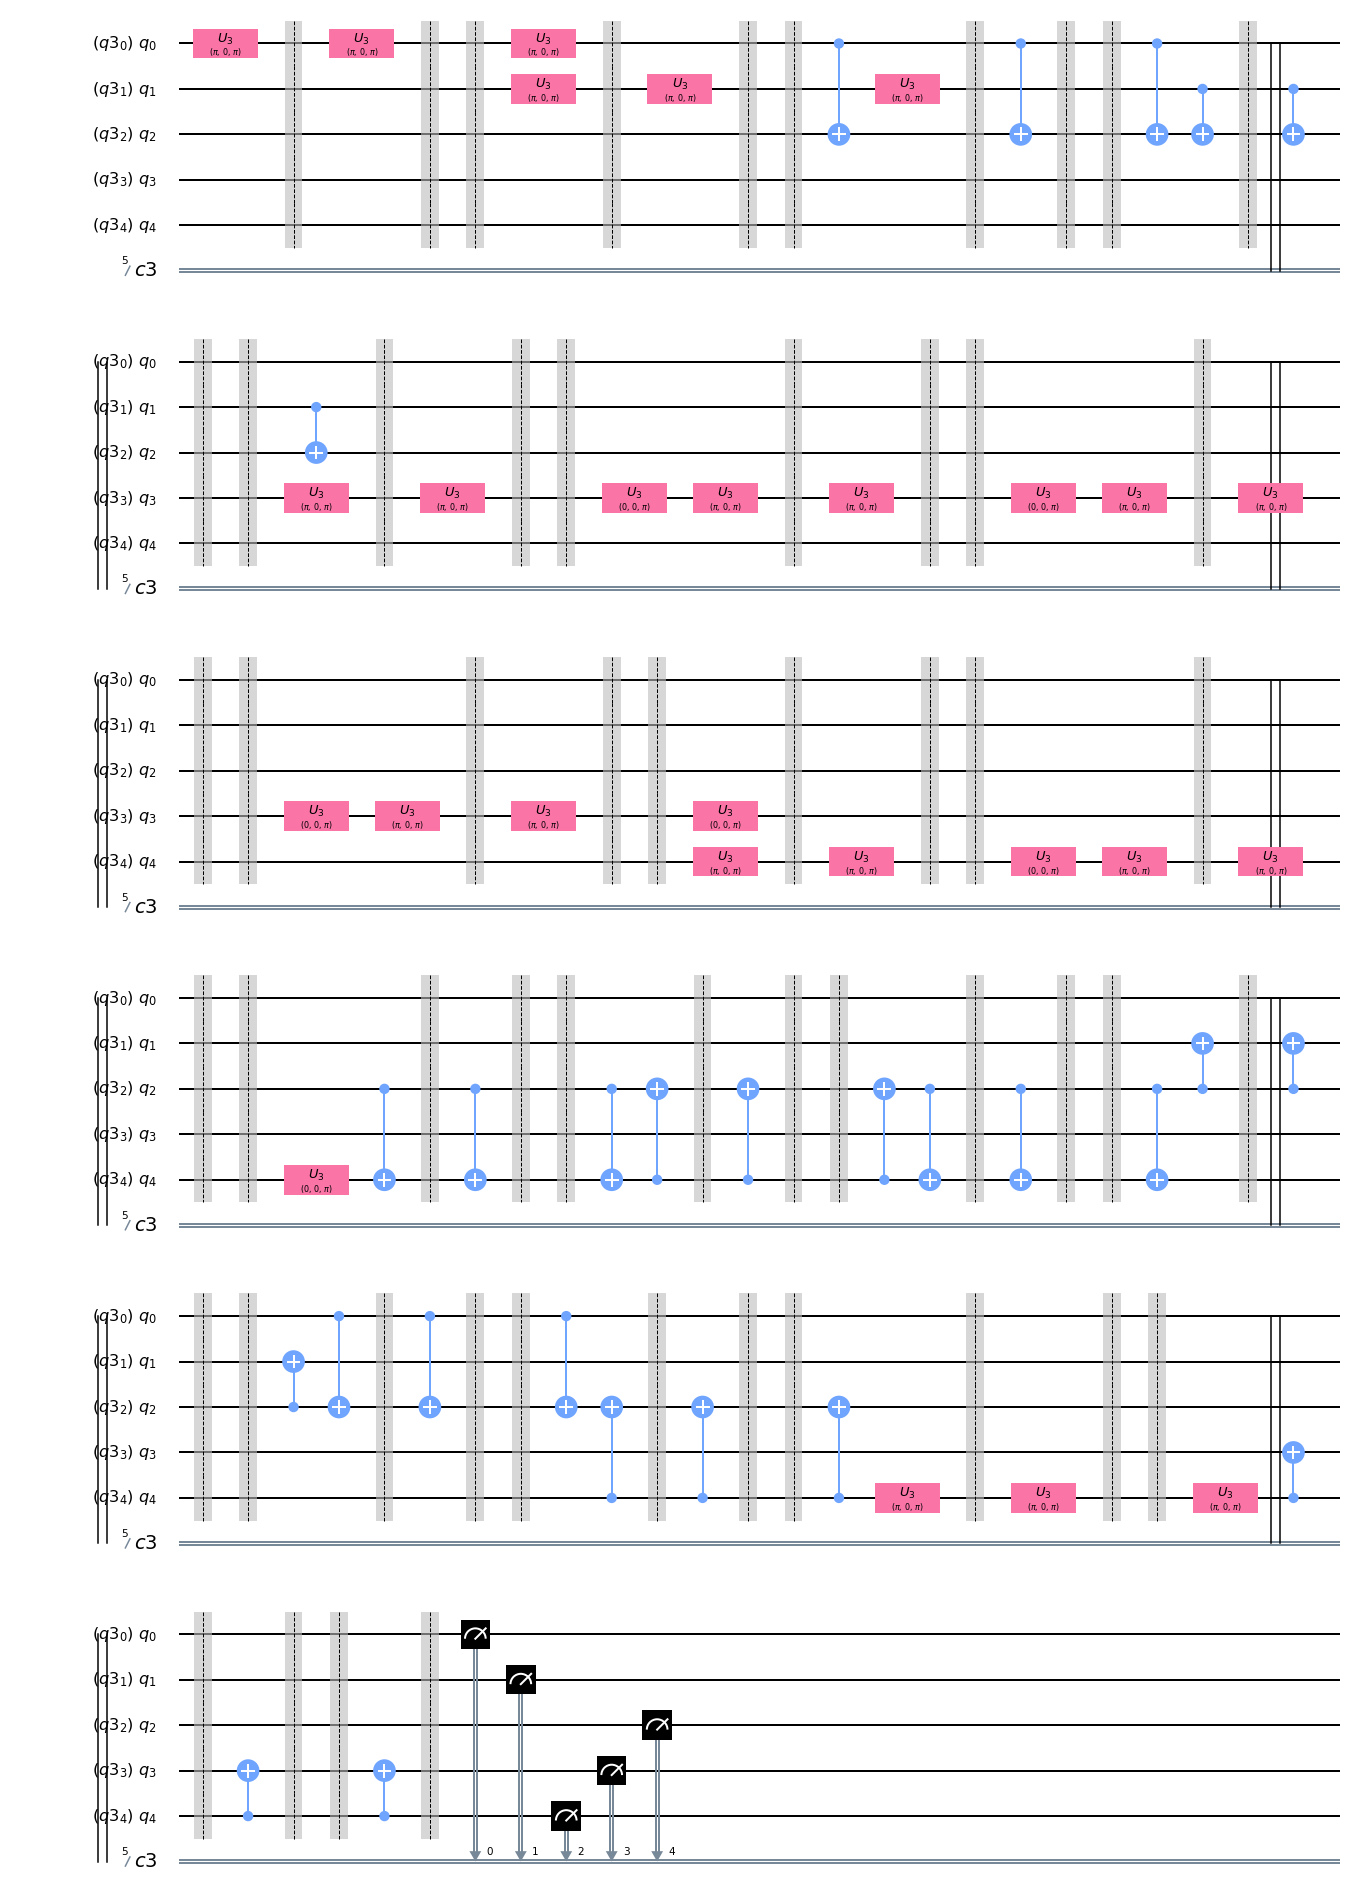

times3 (without barriers):
OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[5];
u3(3.141592653589793,0,3.141592653589793) q[0];
u3(3.141592653589793,0,3.141592653589793) q[1];
cx q[0],q[2];
cx q[1],q[2];
u2(0,3.141592653589793) q[3];
u1(3.141592653589793) q[3];
u1(3.141592653589793) q[3];
u2(0,3.141592653589793) q[3];
u2(0,3.141592653589793) q[4];
u1(3.141592653589793) q[4];
cx q[2],q[4];
cx q[4],q[2];
cx q[2],q[4];
cx q[2],q[1];
cx q[0],q[2];
cx q[4],q[2];
u3(3.141592653589793,0,3.141592653589793) q[4];
cx q[4],q[3];
barrier q[0],q[1],q[4],q[3],q[2];
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[4] -> c[2];
measure q[3] -> c[3];
measure q[2] -> c[4];



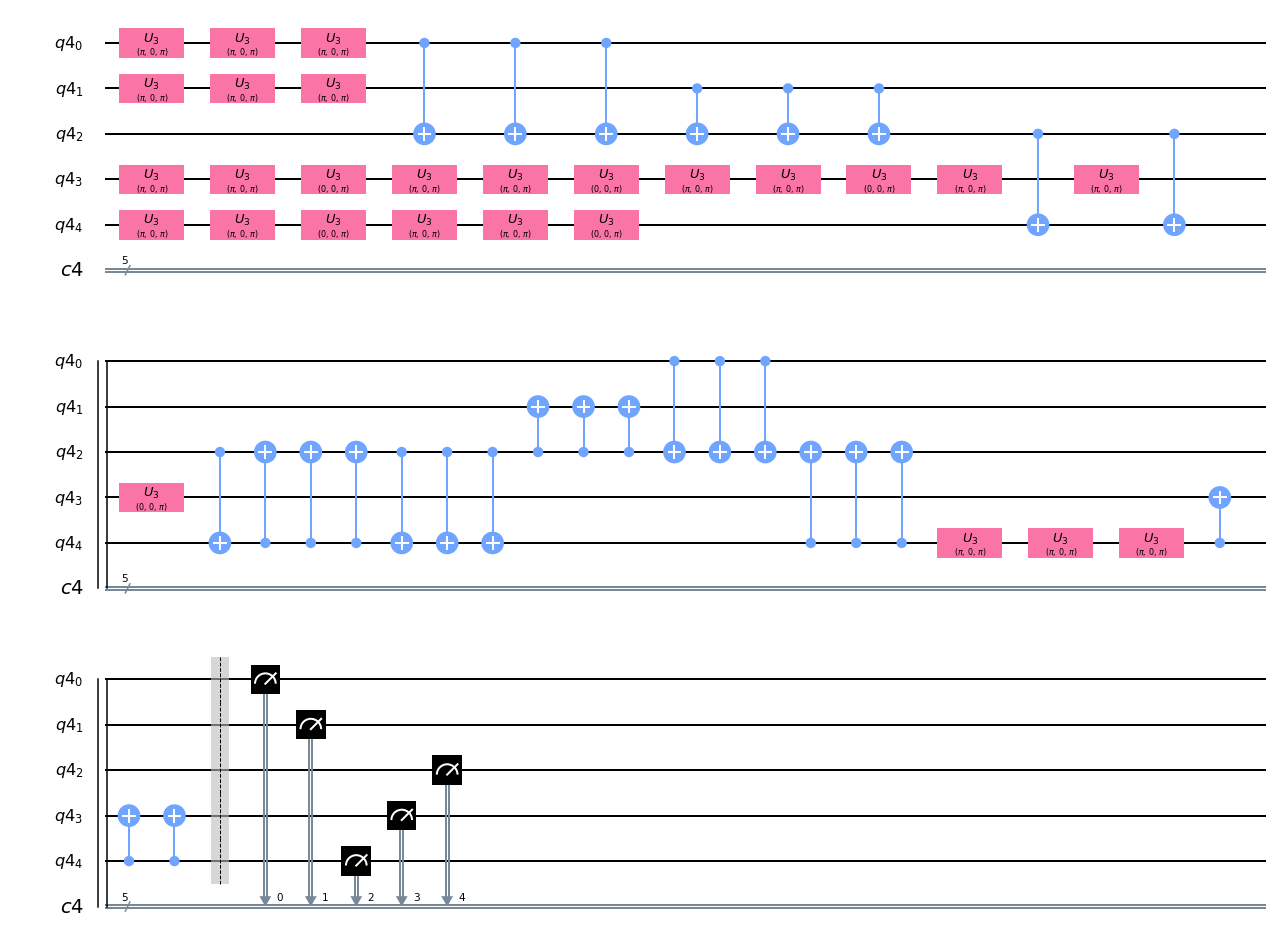

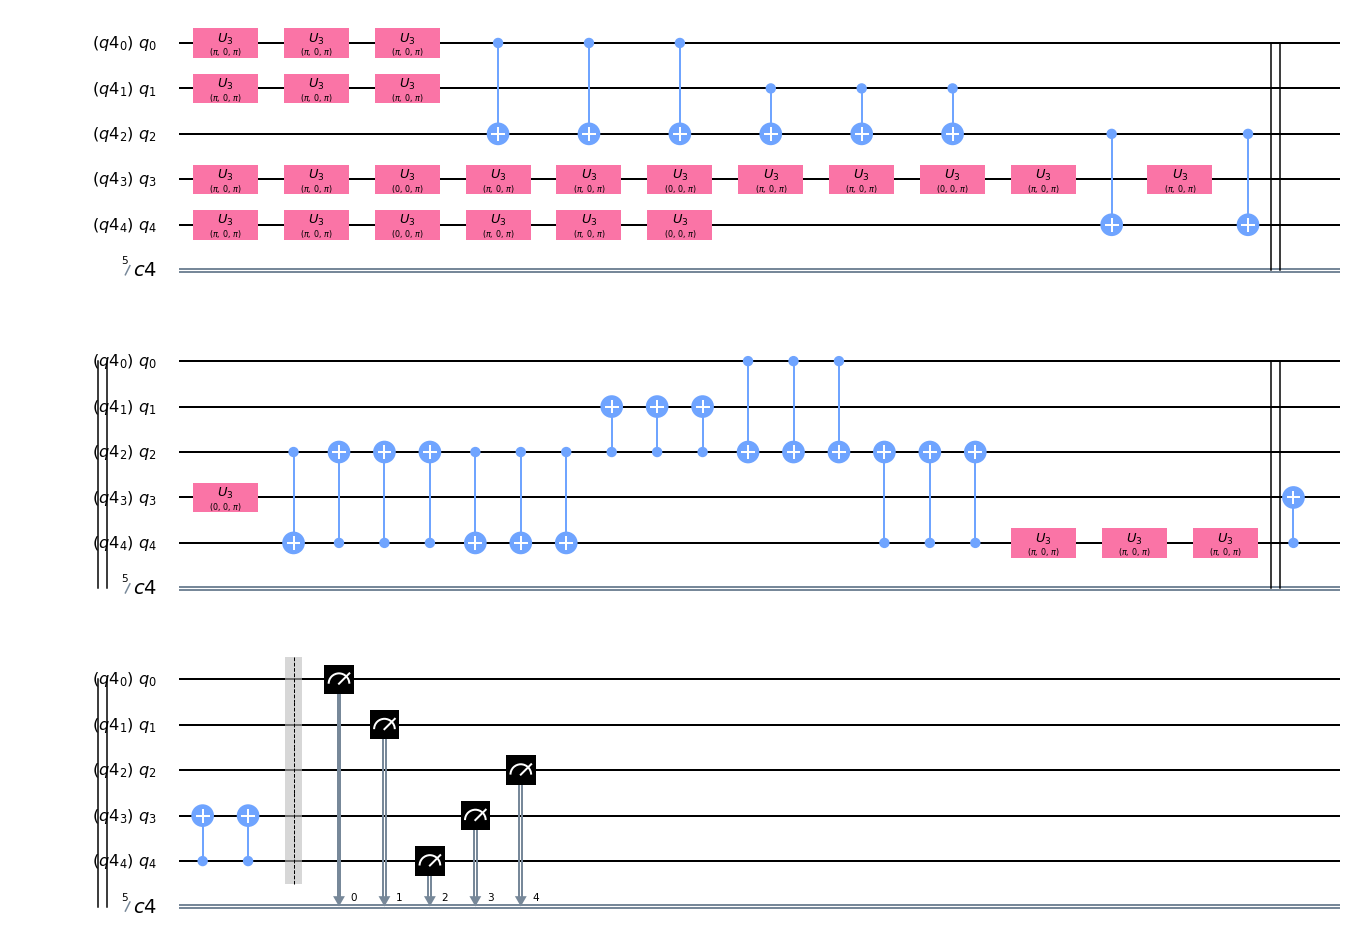

times5:
OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[5];
u3(3.141592653589793,0,3.141592653589793) q[0];
u3(3.141592653589793,0,3.141592653589793) q[1];
cx q[0],q[2];
cx q[1],q[2];
u2(0,3.141592653589793) q[3];
u1(3.141592653589793) q[3];
u1(3.141592653589793) q[3];
u2(0,3.141592653589793) q[3];
u2(0,3.141592653589793) q[4];
u1(3.141592653589793) q[4];
cx q[2],q[4];
cx q[4],q[2];
cx q[2],q[4];
cx q[2],q[1];
cx q[0],q[2];
cx q[4],q[2];
u3(3.141592653589793,0,3.141592653589793) q[4];
cx q[4],q[3];
barrier q[0],q[1],q[4],q[3],q[2];
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[4] -> c[2];
measure q[3] -> c[3];
measure q[2] -> c[4];



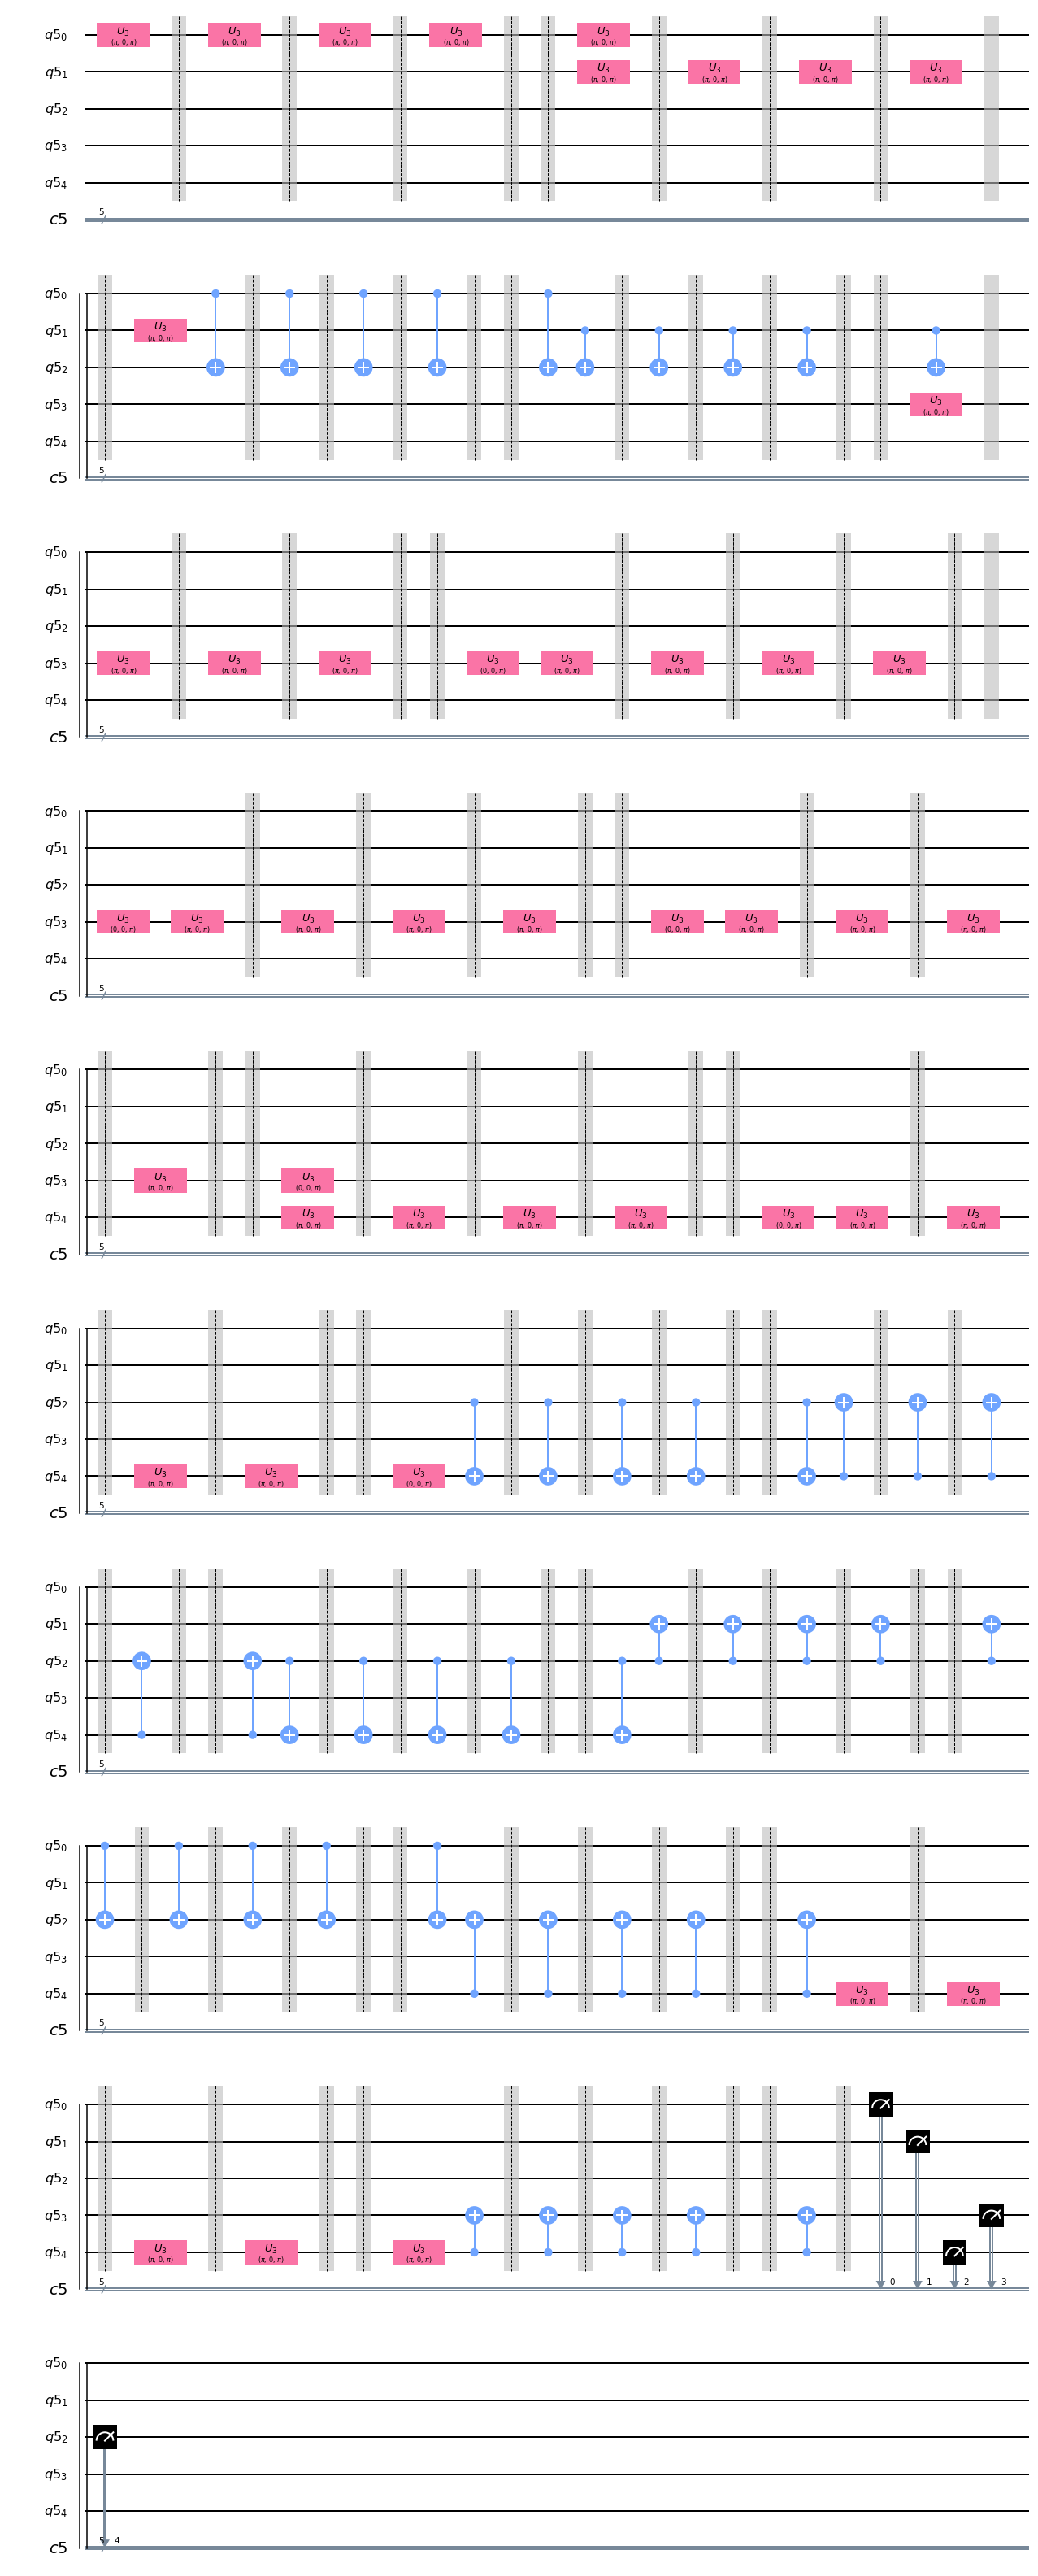

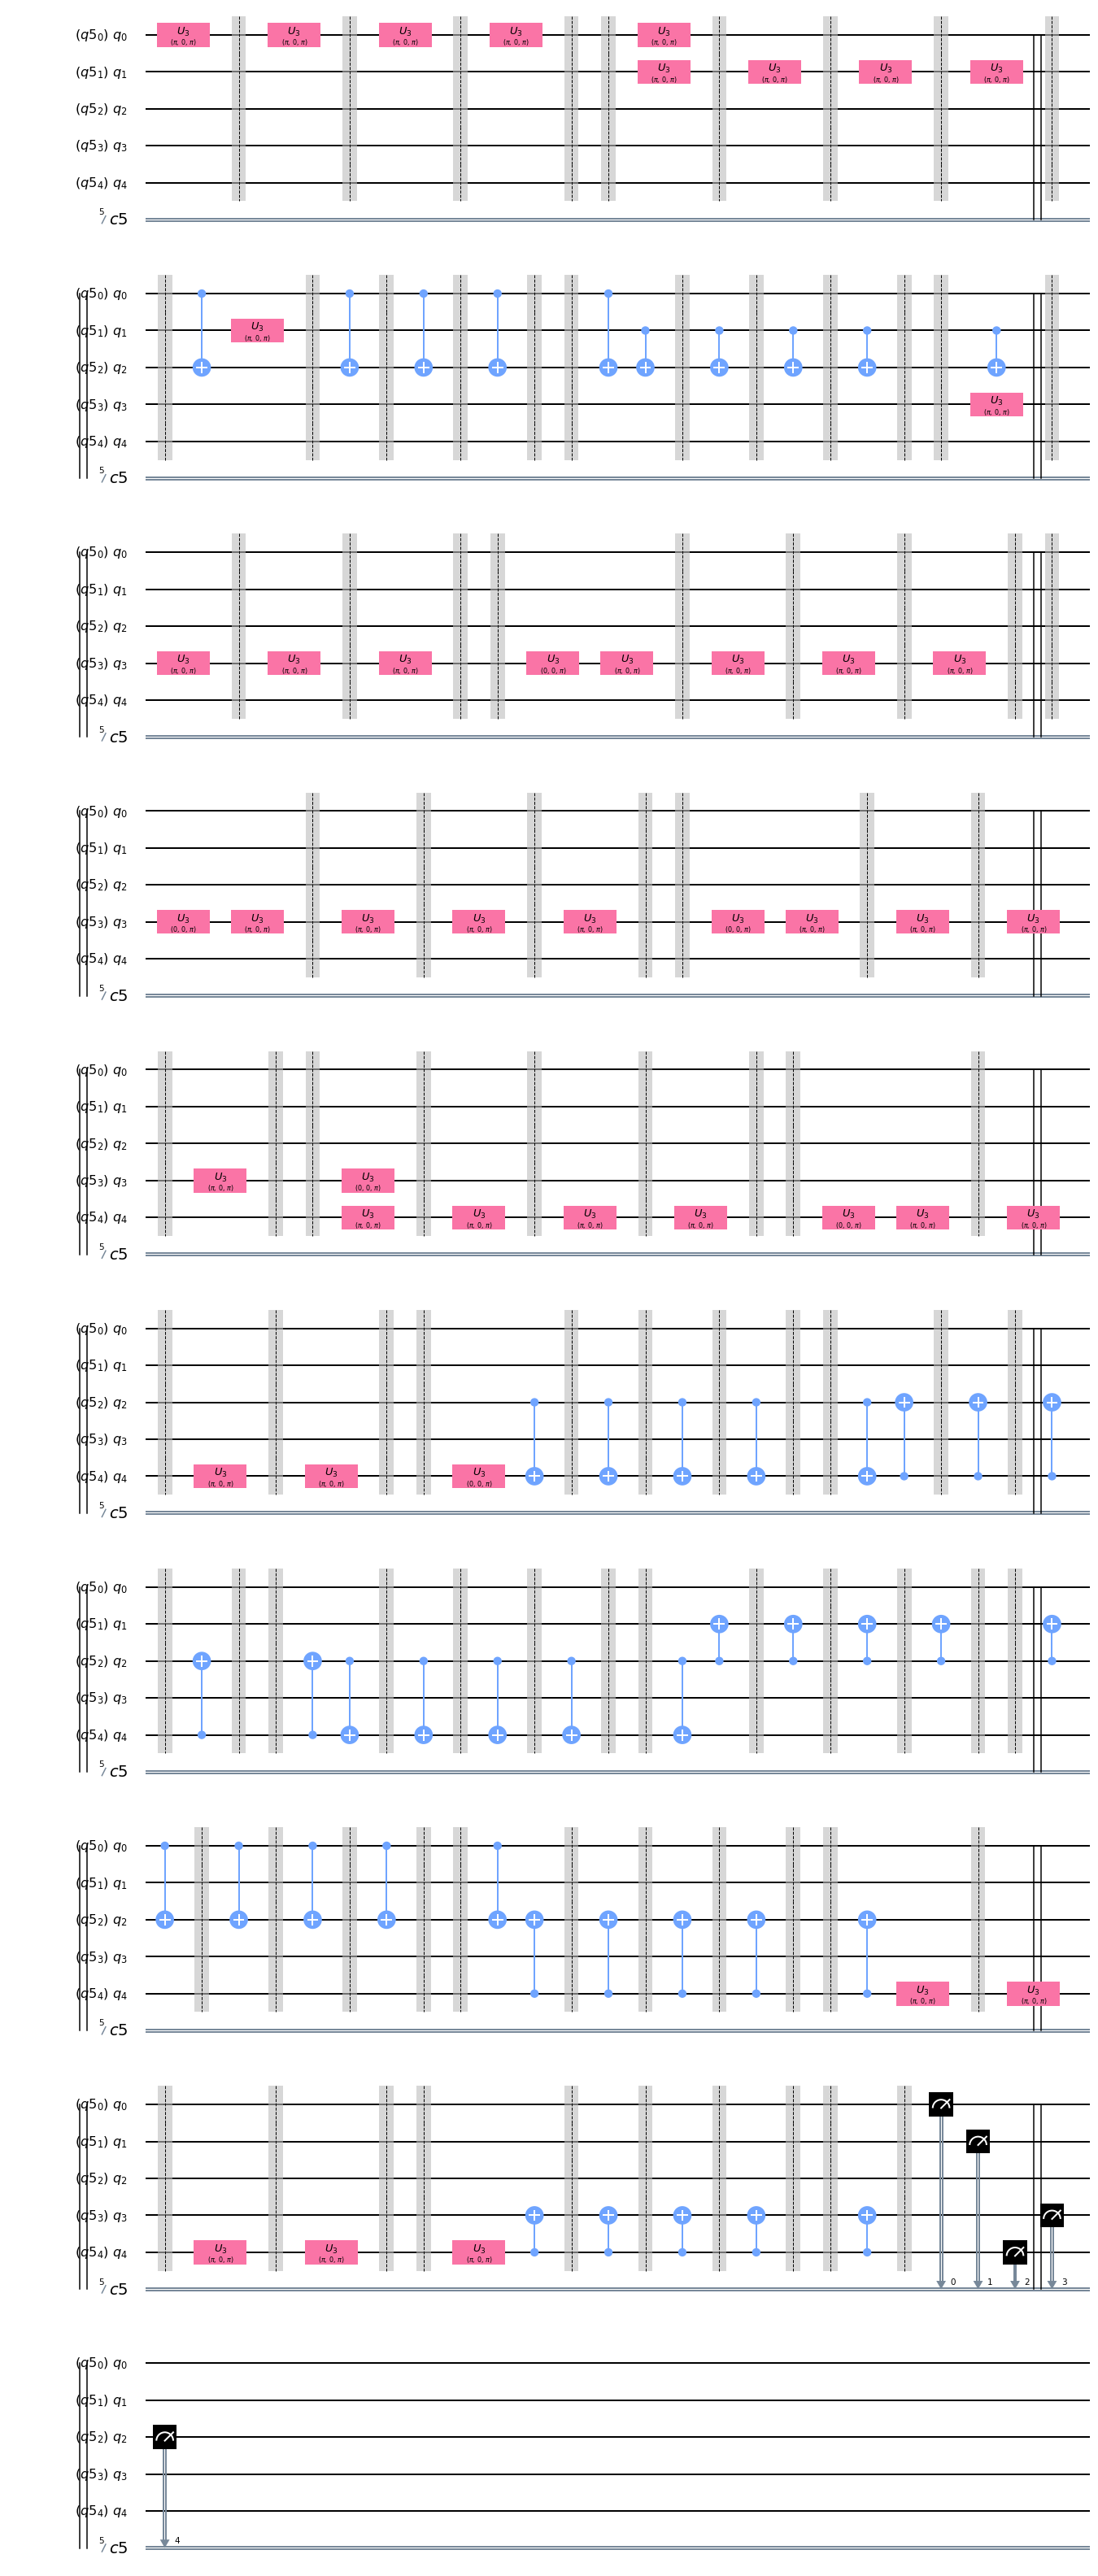

job= backend_qasm_simulator_shots_4096_noisemodel_ibmqx2_errorlevel_times3nb_numcircuits_64_part_1
job= backend_qasm_simulator_shots_4096_noisemodel_ibmqx2_errorlevel_times3nb_numcircuits_64_part_2
job= backend_qasm_simulator_shots_4096_noisemodel_ibmqx2_errorlevel_times3nb_numcircuits_64_part_3
job= backend_qasm_simulator_shots_4096_noisemodel_ibmqx2_errorlevel_times3nb_numcircuits_64_part_4
job= backend_qasm_simulator_shots_4096_noisemodel_ibmqx2_errorlevel_times3nb_numcircuits_64_part_5
job= backend_qasm_simulator_shots_4096_noisemodel_ibmqx2_errorlevel_times3nb_numcircuits_64_part_6
job= backend_qasm_simulator_shots_4096_noisemodel_ibmqx2_errorlevel_times3nb_numcircuits_64_part_7
job= backend_qasm_simulator_shots_4096_noisemodel_ibmqx2_errorlevel_times3nb_numcircuits_64_part_8
job= backend_qasm_simulator_shots_4096_noisemodel_ibmqx2_errorlevel_times5_numcircuits_64_part_1
job= backend_qasm_simulator_shots_4096_noisemodel_ibmqx2_errorlevel_times5_numcircuits_64_part_2
job= backend_q

In [15]:
backendname = backendname_sim
circuit = get_maxs_poker_circuit()
noisemodelname = backendname_x2

print('Original:')
circuit.draw(output='mpl')
circuit = transpile(circuit, backend=backends_dict[backendname_x2], optimization_level=0)
circuit.draw(output='mpl')

print('Anti:')
circuit2 = make_anti_circuit(circuit)
circuit2.draw(output='mpl')
circuit2 = transpile(circuit2, backend=backends_dict[backendname_x2], optimization_level=0)
circuit2.draw(output='mpl')
print('Flip-at-start:')
circuit3 = make_flip_at_start(circuit)
circuit3.draw(output='mpl')
circuit3 = transpile(circuit3, backend=backends_dict[backendname_x2], optimization_level=0)
circuit3.draw(output='mpl')
print('Flip-at-end:')
circuit4 = make_flip_at_end(circuit)
circuit4.draw(output='mpl')
circuit4 = transpile(circuit4, backend=backends_dict[backendname_x2], optimization_level=0)
circuit4.draw(output='mpl')
print('times3:')
circuit5 = make_times3(circuit)
circuit5.draw(output='mpl')
circuit5 = transpile(circuit5, backend=backends_dict[backendname_x2], optimization_level=0)
circuit5.draw(output='mpl')
print('times3 (without barriers):')
circuit6 = make_times3withoutbarriers(circuit)
circuit6.draw(output='mpl')
circuit6 = transpile(circuit6, backend=backends_dict[backendname_x2], optimization_level=0)
circuit6.draw(output='mpl')
print('times5:')
circuit7 = make_times5(circuit)
circuit7.draw(output='mpl')
circuit7 = transpile(circuit7, backend=backends_dict[backendname_x2], optimization_level=0)
circuit7.draw(output='mpl')

#print(noisemodels_dict[noisemodelname])


for mode in ('times3nb', 'times5', 'orig', 'anti', 'flipped-at-start', 'flipped-at-end', 'times3'):
    basename='backend_'+backendname+'_shots_'+str(shots) \
    +'_noisemodel_'+noisemodelname+'_errorlevel_'+mode \
        +'_numcircuits_'+str(num_circuits)
    ### get Expectation value if results exist as files
    #E_tmp, E_av_tmp, success = getE(basename, num_parts)
    success = False
    if success:
        E_dict[basename] = E_tmp
        E_av_dict[basename] = E_av_tmp
        #print('success')
    else:
        mean_depth=0
        max_depth=0
        for p in range(1, num_parts+1):
            circuits_r=[]
            for i in range(1, num_circuits+1):
                if mode == 'anti':
                    circ_tmp = circuit2
                elif mode == 'flipped-at-start':
                    circ_tmp = circuit3
                elif mode == 'flipped-at-end':
                    circ_tmp = circuit4
                elif mode == 'times3':
                    circ_tmp = circuit5
                elif mode == 'times3nb':
                    circ_tmp = circuit6
                elif mode == 'times5':
                    circ_tmp = circuit7
                else:
                    circ_tmp = circuit
                circuits_r.append(circ_tmp)
                depth=circuits_r[-1].depth()
                mean_depth += depth
                max_depth = max(max_depth,depth)
                
            job_string = basename +'_part_'+str(p)
            print('job=',job_string)
            jobs_dict[job_string] = execute(circuits_r, backends_dict[backendname], shots=shots, noise_model=noisemodels_dict[noisemodelname],\
                                                basis_gates=basis_gates_dict[noisemodelname])

            #start_or_retrieve_job(job_string,\
            #backends_dict[backendname],\
            #circuits_r,\
            #options={'shots' : shots})

            mean_depth_dict[basename] = mean_depth/num_repetitions
            max_depth_dict[basename] = max_depth

print('done.')

write the results to file, if not already done and calculate expectation values

In [16]:
backendname = backendname_sim
circuit = get_maxs_poker_circuit()
noisemodelname = backendname_x2


for mode in ('orig', 'anti', 'flipped-at-start', 'flipped-at-end', 'times3', 'times3nb', 'times5'):
    basename='backend_'+backendname+'_shots_'+str(shots) \
        +'_noisemodel_'+noisemodelname+'_errorlevel_'+mode \
        +'_numcircuits_'+str(num_circuits)
    if True: #not(basename in E_dict):
        for p in range(1, num_parts+1):
            job_string = basename +'_part_'+str(p)
            success = write_results(job_string, jobs_dict[job_string])

        E_dict[basename], E_av_dict[basename], success =  getE(basename, num_parts)

<Figure size 800x480 with 0 Axes>

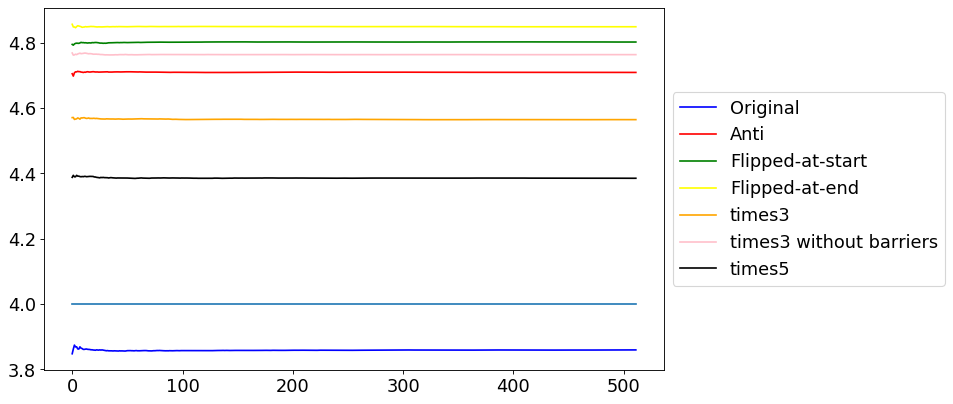

In [17]:
font = {'size' : 16}
pl.matplotlib.rc('font', **font)
pl.figure(1,figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
#backendname = backendname_sim


mode = 'orig'
basename='backend_'+backendname+'_shots_'+str(shots) \
    +'_noisemodel_'+noisemodelname+'_errorlevel_'+ mode \
    +'_numcircuits_'+str(num_circuits)

pl.plot(E_av_dict[basename], color='blue', label='Original')


mode = 'anti'
basename='backend_'+backendname+'_shots_'+str(shots) \
    +'_noisemodel_'+noisemodelname+'_errorlevel_'+ mode \
    +'_numcircuits_'+str(num_circuits)

pl.plot(E_av_dict[basename], color='red', label='Anti')


mode = 'flipped-at-start'
basename='backend_'+backendname+'_shots_'+str(shots) \
    +'_noisemodel_'+noisemodelname+'_errorlevel_'+ mode \
    +'_numcircuits_'+str(num_circuits)

pl.plot(5 - E_av_dict[basename], color='green', label='Flipped-at-start')


mode = 'flipped-at-end'
basename='backend_'+backendname+'_shots_'+str(shots) \
    +'_noisemodel_'+noisemodelname+'_errorlevel_'+ mode \
    +'_numcircuits_'+str(num_circuits)

pl.plot(5 - E_av_dict[basename], color ='yellow', label='Flipped-at-end')

mode = 'times3'
basename='backend_'+backendname+'_shots_'+str(shots) \
    +'_noisemodel_'+noisemodelname+'_errorlevel_'+ mode \
    +'_numcircuits_'+str(num_circuits)

pl.plot(E_av_dict[basename], color ='orange', label='times3')

mode = 'times3nb'
basename='backend_'+backendname+'_shots_'+str(shots) \
    +'_noisemodel_'+noisemodelname+'_errorlevel_'+ mode \
    +'_numcircuits_'+str(num_circuits)

pl.plot(E_av_dict[basename], color ='pink', label='times3 without barriers')

mode = 'times5'
basename='backend_'+backendname+'_shots_'+str(shots) \
    +'_noisemodel_'+noisemodelname+'_errorlevel_'+ mode \
    +'_numcircuits_'+str(num_circuits)

pl.plot(E_av_dict[basename], color ='black', label='times5')
pl.legend(loc='center left', bbox_to_anchor=(1, 0.5))

pl.plot(4*np.ones_like(E_av_dict[basename]))

In [ ]:
print(circuit2.qasm())